In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scarlet
import logging

import tensorflow_hub as hub
import tensorflow as tf
logger = logging.getLogger('scarlet')
logger.setLevel(logging.DEBUG)

In [3]:
import proxmin
import proxmin.operators

In [4]:
module_path='modules/pixelcnn_out'
pixelcnn = hub.Module(module_path)
sess= tf.Session()
sess.run(tf.global_variables_initializer())

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [139]:
# Building a blend object
import galsim

data_dir='/usr/local/share/galsim/COSMOS_25.2_training_sample'
cat = galsim.COSMOSCatalog(dir=data_dir)

# Let's build a scene
im = galsim.Image(65, 65, scale=0.06)

gals=[1,5]

gal1 = cat.makeGalaxy(1)
gal2 = cat.makeGalaxy(2)
scene = galsim.Add([gal1, gal2.shift(dx=0.06*10,dy=0)])

scene = galsim.Convolve(scene, gal1.original_psf)

scene.drawImage(im);


im1 = galsim.Image(33, 33, scale=0.06)
im2 = galsim.Image(33, 33, scale=0.06)

galsim.Convolve(gal1, gal1.original_psf).drawImage(im1);
galsim.Convolve(gal2, gal1.original_psf).drawImage(im2);

from astropy.io import fits
fits.writeto('blend.fits', im.array)
fits.writeto('gal1.fits', im1.array)
fits.writeto('gal2.fits', im2.array)

In [141]:
im = fits.getdata('blend.fits')
im1 = fits.getdata('gal1.fits')
im2 = fits.getdata('gal2.fits')

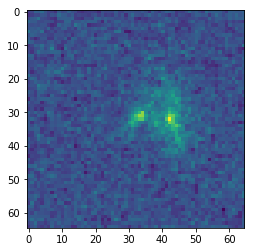

In [142]:
imshow(im)

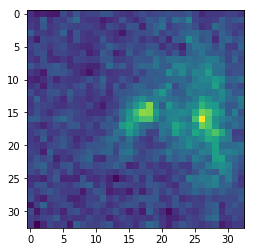

In [143]:
imshow(im[16:-16,16:-16]);

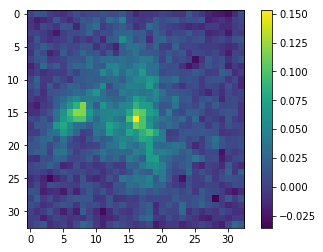

In [146]:
imshow(im[16:-16,26:-6]);colorbar()

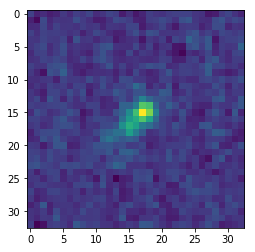

In [147]:
imshow(im1)

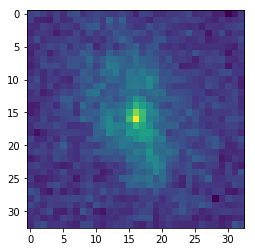

In [148]:
imshow(im2)

In [92]:
class PixelCNNConstraint(scarlet.Constraint):
    
    def __init__(self, module, session):
        self.x = tf.placeholder(shape=(1,32,32,1), dtype=tf.float32)
        self.pixelcnn = module(self.x, as_dict=True)['grads']
        self.session = session

    def prox_pixelcnn(self, X, step):
        grad = self.session.run(self.pixelcnn, feed_dict={self.x: X[1:,1:].reshape((1,32,32,1))})
        grad = np.pad(grad[0,:,:,0],((1,0), (1,0)), mode='wrap')
        res = X - 2e-5*step*grad        
        return res

    def prox_sed(self, shape):
        return proxmin.operators.prox_plus

    def prox_morph(self, shape):
        return self.prox_pixelcnn

In [93]:
config = scarlet.Config(source_sizes=[33], accelerated=False)

In [94]:
img = im.reshape((1,65,65))
sources = [scarlet.ExtendedSource((32, 32), img, bg_rms=array([0.03]), config=config, constraints=PixelCNNConstraint(pixelcnn, sess), normalization=None, fix_sed=True, symmetric=False, monotonic=False),
           scarlet.ExtendedSource((32, 42), img, bg_rms=array([0.03]), config=config, constraints=PixelCNNConstraint(pixelcnn, sess), normalization=None, fix_sed=True, symmetric=False, monotonic=False)]

blend = scarlet.Blend(sources).set_data(img, config=config)

INFO:scarlet.blend:max source size 33 smaller than image size (65,65); truncation possible


(33, 33)

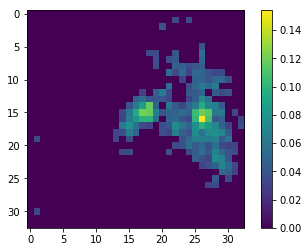

In [95]:
imshow(sources[0][0].morph)
colorbar()
sources[0][0].morph.shape



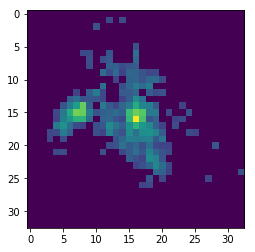

In [96]:
plt.figure()
plt.imshow(sources[1][0].morph)
plt.show()

In [138]:
blend.fit(steps=1000, e_rel=1e-6)

DEBUG:scarlet.blend:shifting component (0, 0) by (0.000/-0.001) to (31.813/31.689) in it 4210
INFO:scarlet.blend:resizing component (0, 0) from (33,33) to (33,33) at it 4210
INFO:scarlet.blend:resizing component (1, 0) from (33,33) to (33,33) at it 4210
DEBUG:scarlet.blend:shifting component (0, 0) by (0.000/-0.001) to (31.813/31.688) in it 4220
INFO:scarlet.blend:resizing component (0, 0) from (33,33) to (33,33) at it 4220
INFO:scarlet.blend:resizing component (1, 0) from (33,33) to (33,33) at it 4220
DEBUG:scarlet.blend:shifting component (0, 0) by (0.000/-0.001) to (31.813/31.687) in it 4230
INFO:scarlet.blend:resizing component (0, 0) from (33,33) to (33,33) at it 4230
INFO:scarlet.blend:resizing component (1, 0) from (33,33) to (33,33) at it 4230
DEBUG:scarlet.blend:shifting component (0, 0) by (0.000/-0.001) to (31.813/31.685) in it 4240
INFO:scarlet.blend:resizing component (0, 0) from (33,33) to (33,33) at it 4240
INFO:scarlet.blend:resizing component (1, 0) from (33,33) to (33

INFO:scarlet.blend:resizing component (0, 0) from (33,33) to (33,33) at it 4530
INFO:scarlet.blend:resizing component (1, 0) from (33,33) to (33,33) at it 4530
DEBUG:scarlet.blend:shifting component (0, 0) by (0.000/-0.003) to (31.813/31.621) in it 4540
DEBUG:scarlet.blend:shifting component (1, 0) by (0.000/-0.001) to (31.869/41.851) in it 4540
INFO:scarlet.blend:resizing component (0, 0) from (33,33) to (33,33) at it 4540
INFO:scarlet.blend:resizing component (1, 0) from (33,33) to (33,33) at it 4540
DEBUG:scarlet.blend:shifting component (0, 0) by (0.000/-0.003) to (31.813/31.618) in it 4550
DEBUG:scarlet.blend:shifting component (1, 0) by (0.000/-0.001) to (31.869/41.850) in it 4550
INFO:scarlet.blend:resizing component (0, 0) from (33,33) to (33,33) at it 4550
INFO:scarlet.blend:resizing component (1, 0) from (33,33) to (33,33) at it 4550
DEBUG:scarlet.blend:shifting component (0, 0) by (0.000/-0.003) to (31.813/31.615) in it 4560
DEBUG:scarlet.blend:shifting component (1, 0) by (

DEBUG:scarlet.blend:shifting component (0, 0) by (-0.000/-0.004) to (31.813/31.531) in it 4780
DEBUG:scarlet.blend:shifting component (1, 0) by (-0.000/-0.001) to (31.866/41.829) in it 4780
INFO:scarlet.blend:resizing component (0, 0) from (33,33) to (33,33) at it 4780
INFO:scarlet.blend:resizing component (1, 0) from (33,33) to (33,33) at it 4780
DEBUG:scarlet.blend:shifting component (0, 0) by (-0.000/-0.004) to (31.813/31.527) in it 4790
INFO:scarlet.blend:resizing component (0, 0) from (33,33) to (33,33) at it 4790
INFO:scarlet.blend:resizing component (1, 0) from (33,33) to (33,33) at it 4790
DEBUG:scarlet.blend:shifting component (0, 0) by (-0.000/-0.004) to (31.813/31.523) in it 4800
INFO:scarlet.blend:resizing component (0, 0) from (33,33) to (33,33) at it 4800
INFO:scarlet.blend:resizing component (1, 0) from (33,33) to (33,33) at it 4800
DEBUG:scarlet.blend:shifting component (0, 0) by (-0.000/-0.004) to (31.813/31.519) in it 4810
DEBUG:scarlet.blend:shifting component (1, 0)

INFO:scarlet.blend:resizing component (1, 0) from (33,33) to (33,33) at it 5030
DEBUG:scarlet.blend:shifting component (0, 0) by (0.000/-0.010) to (31.815/31.385) in it 5040
DEBUG:scarlet.blend:shifting component (1, 0) by (-0.000/-0.003) to (31.857/41.791) in it 5040
INFO:scarlet.blend:resizing component (0, 0) from (33,33) to (33,33) at it 5040
INFO:scarlet.blend:resizing component (1, 0) from (33,33) to (33,33) at it 5040
DEBUG:scarlet.blend:shifting component (0, 0) by (0.000/-0.010) to (31.815/31.375) in it 5050
DEBUG:scarlet.blend:shifting component (1, 0) by (-0.000/-0.003) to (31.857/41.788) in it 5050
INFO:scarlet.blend:resizing component (0, 0) from (33,33) to (33,33) at it 5050
INFO:scarlet.blend:resizing component (1, 0) from (33,33) to (33,33) at it 5050
DEBUG:scarlet.blend:shifting component (0, 0) by (0.000/-0.011) to (31.815/31.364) in it 5060
DEBUG:scarlet.blend:shifting component (1, 0) by (-0.000/-0.003) to (31.856/41.785) in it 5060
INFO:scarlet.blend:resizing compo

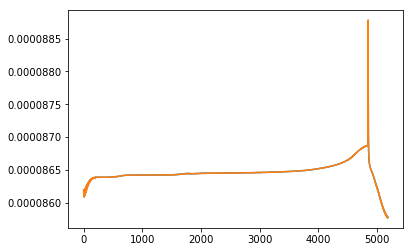

In [149]:
plot(blend.mse[10:])

In [150]:
blend.get_model().shape

(1, 65, 65)

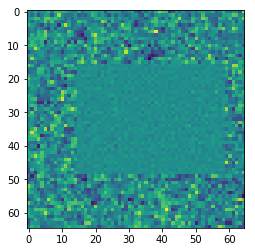

In [151]:
imshow(blend.get_model()[0] - img[0])

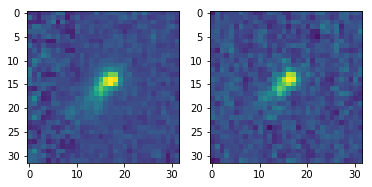

In [159]:
subplot(121)
imshow(blend.components[0].morph[1:,1:],vmax=0.1,vmin=-0.03)
subplot(122)
imshow(im1[1:,1:],vmax=0.1,vmin=-0.03)

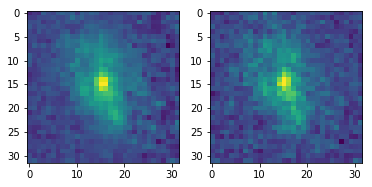

In [162]:
subplot(121)
imshow(blend.components[1].morph[1:,1:],vmax=0.12,vmin=-0.03)
subplot(122)
imshow(im2[1:,1:],vmax=0.12,vmin=-0.03)

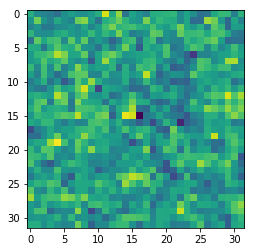

In [164]:
imshow(im2[1:,1:] - blend.components[1].morph[1:,1:])